<a href="https://colab.research.google.com/github/joheras/MusicaCatedralStoDomingoIER/blob/main/Notebooks/SacarM%C3%BAsica/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ice Vision

## Librerías

In [ ]:
%%capture
!pip install icevision[all]==0.5.1
!pip install torchtext==0.8.1

In [ ]:
from fastai.vision.all import *
from icevision.all import *

In [ ]:
%%capture
!unzip dataset.zip

## Parser
Para archivos .json (también vale para .txt) que contengan información de la forma:

  [{'bbox' : [xmin,ymin,xmax,ymax], 'label' : nombre},{},...]

In [ ]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    pass

In [ ]:
AnotacionParser.generate_template()

def __iter__(self) -> Any:
def imageid(self, o) -> Hashable:
def image_width_height(self, o) -> Tuple[int, int]:
    return get_image_size(self.filepath(o))
def filepath(self, o) -> Union[str, Path]:
def bboxes(self, o) -> List[BBox]:
def labels(self, o) -> List[int]:


In [ ]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    def __init__(self, path_img,path_anotaciones):
        self.path_img = path_img
        self.path_anotaciones= path_anotaciones

    def __iter__(self):
      with os.scandir(self.path_anotaciones) as ficheros:
        for fichero in ficheros:
          if fichero.name!='.ipynb_checkpoints':
            yield fichero.name

    def imageid(self, o) -> Hashable: #o --> nombre de la anotación
      return o[:o.find('.')]

    def filepath(self, o) -> Union[str, Path]:
      path=Path(f"{o[:o.find('.')]}.jpg")
      return self.path_img / path

    def image_width_height(self, o) -> Tuple[int, int]:
      return get_image_size(self.path_img+'/'+f"{o[:o.find('.')]}.jpg")

    def labels(self, o) -> List[int]:
      d={'background':0,'claved':1, 'claves':2, 'clavef':3, 'nota1':4, 'nota2':5, 'nota4':6, 'nota1:2':7, 'nota1:4':8, 'notae':9, 'sos':10, 'bem':11, 'bec':12, 'sil0':13, 'sil1':14, 'sil2':15, 'sil1:2':16, 'sil1:4':17, '2x4':18, '3x4':19, '4x4':20, '6x8':21, 'punt':22, 'liga':23,'3':24,'line':25,'P2':26, 'nota1:8':27, 'cal':28, '3x2':29,'mf':30,'P1':31,'check':32,'3x8':33,'2x2':34}
      path=self.path_anotaciones+'/'+o
      anotacion=json.loads(open(path).read())
      label=[]
      for L in anotacion:
        label.append(d[L['label']])
      return label

    def bboxes(self, o) -> List[BBox]:
      path=self.path_anotaciones+'/'+o
      anotacion=json.loads(open(path).read())
      bbox=[]
      for L in anotacion:
        bbox.append(BBox.from_xyxy(L['box'][0],L['box'][1],L['box'][2],L['box'][3]))
      return bbox

## Parser

- **train parser**

In [ ]:
anot = AnotacionParser('dataset/train/images','dataset/train/annotations')

- **test parser**

In [ ]:
anot_test = AnotacionParser('dataset/test/images','dataset/test/annotations')

## Records

In [ ]:
%%capture
train_rs, valid_rs = anot.parse()
test_rs,_=anot_test.parse(RandomSplitter((1, 0)))

INFO     - Autofixing records | icevision.parsers.parser:parse:126


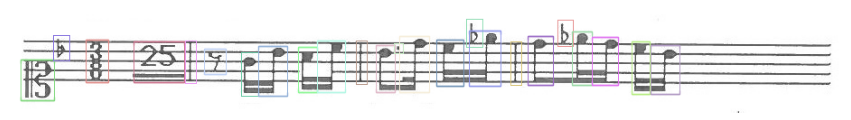

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 20))
show_record(train_rs[23], display_label=False,ax=ax)

In [ ]:
len(train_rs)/(len(train_rs)+len(valid_rs))

0.7974137931034483

## FasterRCNN

In [ ]:
class EarlyStoppingMAP(fastai.EarlyStoppingCallback):
  def __init__(self, monitor='valid_loss', comp=None, min_delta=0., patience=5, reset_on_fit=True):
    super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, patience=patience,reset_on_fit=reset_on_fit)

  def before_fit(self):
    self.wait = 0; super().before_fit()

  def after_epoch(self):
    "Compare the value monitored to its best score and maybe stop training."
    val = self.recorder.values[-1][self.idx]
    if self.comp(val, self.best):
      self.best, self.new_best = val, True
    else:
      self.new_best = False


    if self.new_best:
      self.wait = 0
    else:
      self.wait += 1
      if self.wait >= self.patience:
        print(f'No improvement since epoch {self.epoch-self.wait}: early stopping')
        raise fastai.CancelFitException()

class SaveModelMAP(fastai.SaveModelCallback):
  def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, with_opt=False,
               reset_on_fit=True):
    super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, fname=fname,every_epoch=every_epoch, with_opt=with_opt,
                     reset_on_fit=reset_on_fit)

  def _save(self, name):
    super()._save(name)

  def after_epoch(self):
    "Compare the value monitored to its best score and save if best."
    if self.every_epoch:
      self._save(f'{self.fname}_{self.epoch}')
    else:  # every improvement
      val = self.recorder.values[-1][self.idx]
      if self.comp(val, self.best):
        self.best, self.new_best = val, True
      else:
        self.new_best = False

      if self.new_best:
        print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
        self._save(f'{self.fname}')

  def after_fit(self, **kwargs):
    "Load the best model."
    super().after_fit(**kwargs)


class ReduceLRMAP(fastai.ReduceLROnPlateau):
  def __init__(self, monitor='valid_loss', comp=None, min_delta=0., patience=1, factor=10., min_lr=0,
               reset_on_fit=True):
    super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, patience=patience,factor=factor,min_lr=min_lr,
                     reset_on_fit=reset_on_fit)

  def before_fit(self):
    self.wait = 0; super().before_fit()

  def after_epoch(self):
    "Compare the value monitored to its best score and reduce LR by `factor` if no improvement."
    val = self.recorder.values[-1][self.idx]
    if self.comp(val, self.best):
      self.best, self.new_best = val, True
    else:
      self.new_best = False

    if self.new_best:
      self.wait = 0
    else:
      self.wait += 1
      if self.wait >= self.patience:
        old_lr = self.opt.hypers[-1]['lr']
        for h in self.opt.hypers: h['lr'] = max(h['lr'] / self.factor, self.min_lr)
        self.wait = 0
        if self.opt.hypers[-1]["lr"] < old_lr:
          print(f'Epoch {self.epoch}: reducing lr to {self.opt.hypers[-1]["lr"]}')


def compareM(x1,x2):
  if isinstance(x1,dict):
    x1=float(x1['mAP'])
  if isinstance(x2,dict):
    x2=float(x2['mAP'])
  return np.greater(x1,x2)

In [ ]:
model = faster_rcnn.model(num_classes=35)

In [ ]:
presize = 926
size = 926

In [ ]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize,shift_scale_rotate=None,crop_fn=None, horizontal_flip=None, pad=None), tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(train_rs, train_tfms)
valid_ds = Dataset(valid_rs, valid_tfms)

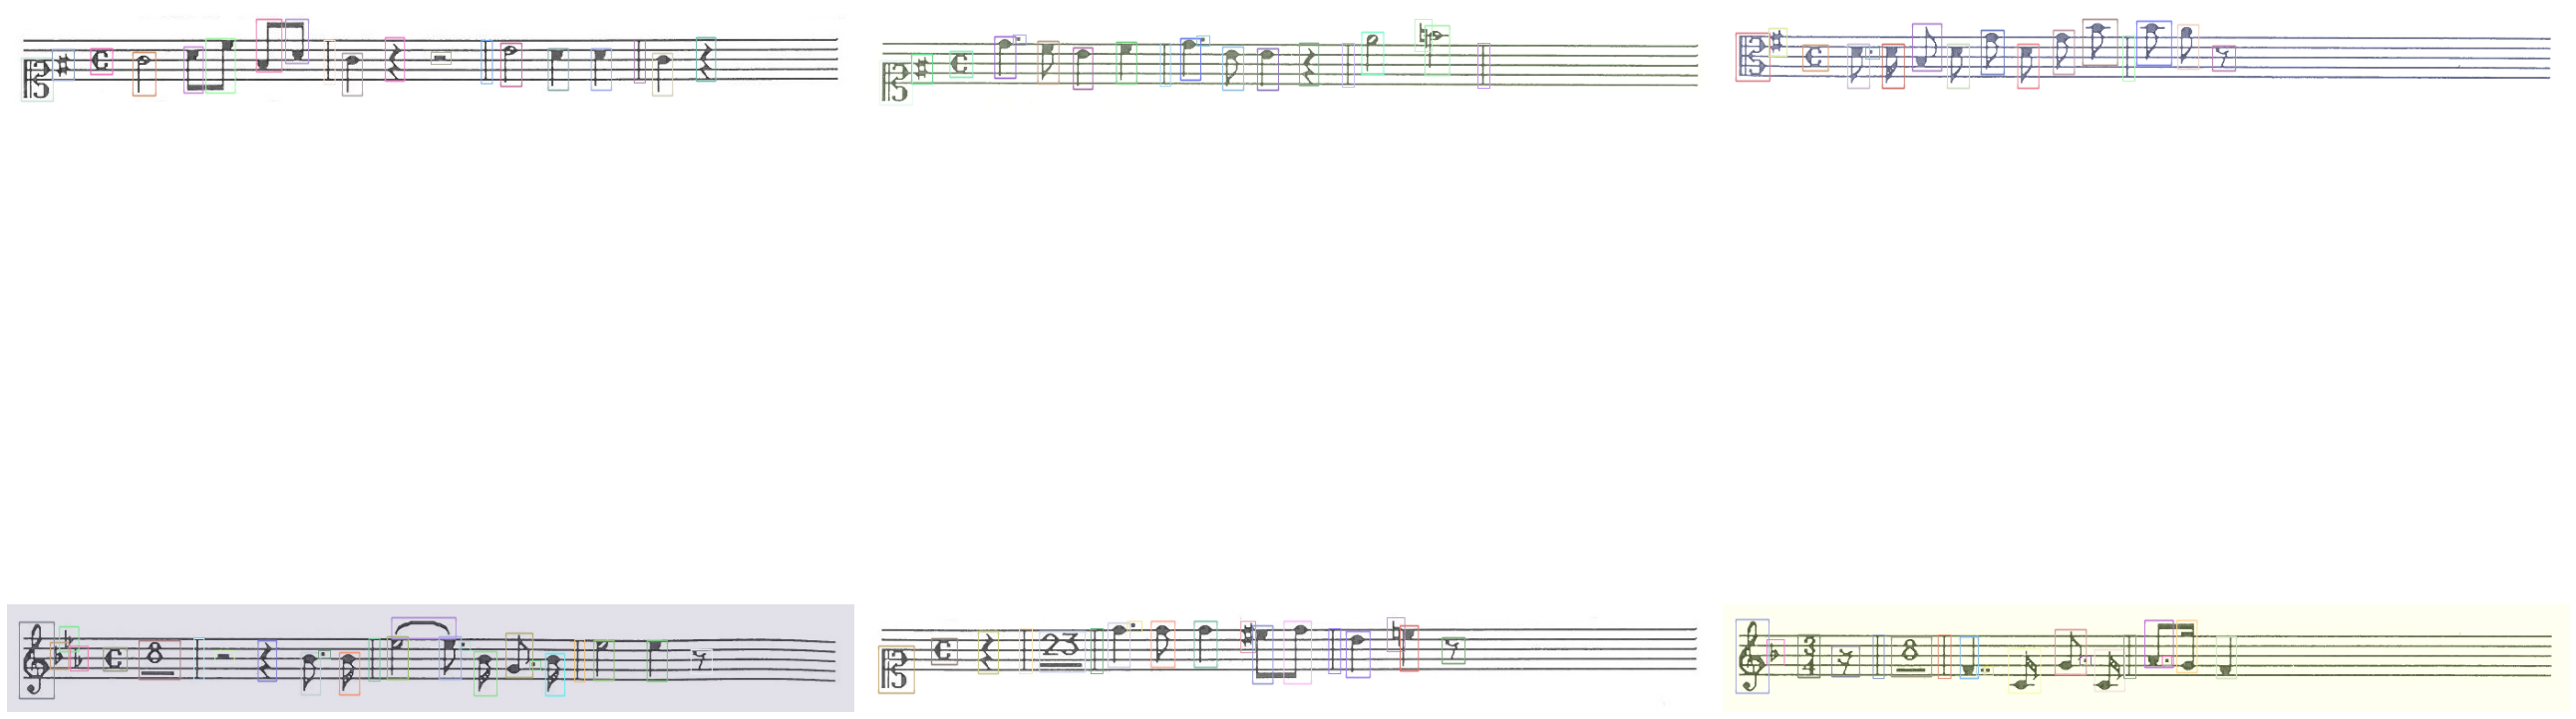

In [ ]:
samples = [train_ds[i] for i in range(6)]
show_samples(samples, denormalize_fn=denormalize_imagenet, ncols=3, display_label=False, show=True)

In [ ]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [ ]:
saveM=SaveModelMAP(monitor='COCOMetric',fname='FasterRCMM',comp=compareM)
lrReduce=ReduceLRMAP(monitor='COCOMetric',patience=3, factor=10.0, min_lr=0,comp=compareM)
early=EarlyStoppingMAP(monitor='COCOMetric',patience=5,comp=compareM)

In [ ]:
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics,cbs=[saveM,lrReduce,early])

In [ ]:
print(learn.recorder.metrics)
(min_lr,steep)=learn.lr_find(show_plot=True)

In [ ]:
learn.fine_tune(150, steep, freeze_epoch=2)

In [ ]:
torch.save(model.state_dict(),'mejor.pth')

In [ ]:
faster_rcnn.show_results(model, valid_ds)

## Inferencia

In [ ]:
state_dict = torch.load('mejor.pth')
model = faster_rcnn.model(num_classes=33)

In [ ]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
test1=cv2.imread('/content/dataset/test/images/pent189.jpg')
test2=cv2.imread('/content/dataset/test/images/pent280.jpg')
test3=cv2.imread('/content/dataset/test/images/super_mario_theme7.jpg')

In [ ]:
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=600), tfms.A.Normalize()])
infer_ds = Dataset.from_images([test1,test2,test3], infer_tfms)
infer_dl = faster_rcnn.infer_dl(infer_ds, batch_size=1)
samples, preds = faster_rcnn.predict_dl(model=model, infer_dl=infer_dl)

  0%|          | 0/3 [00:00<?, ?it/s]

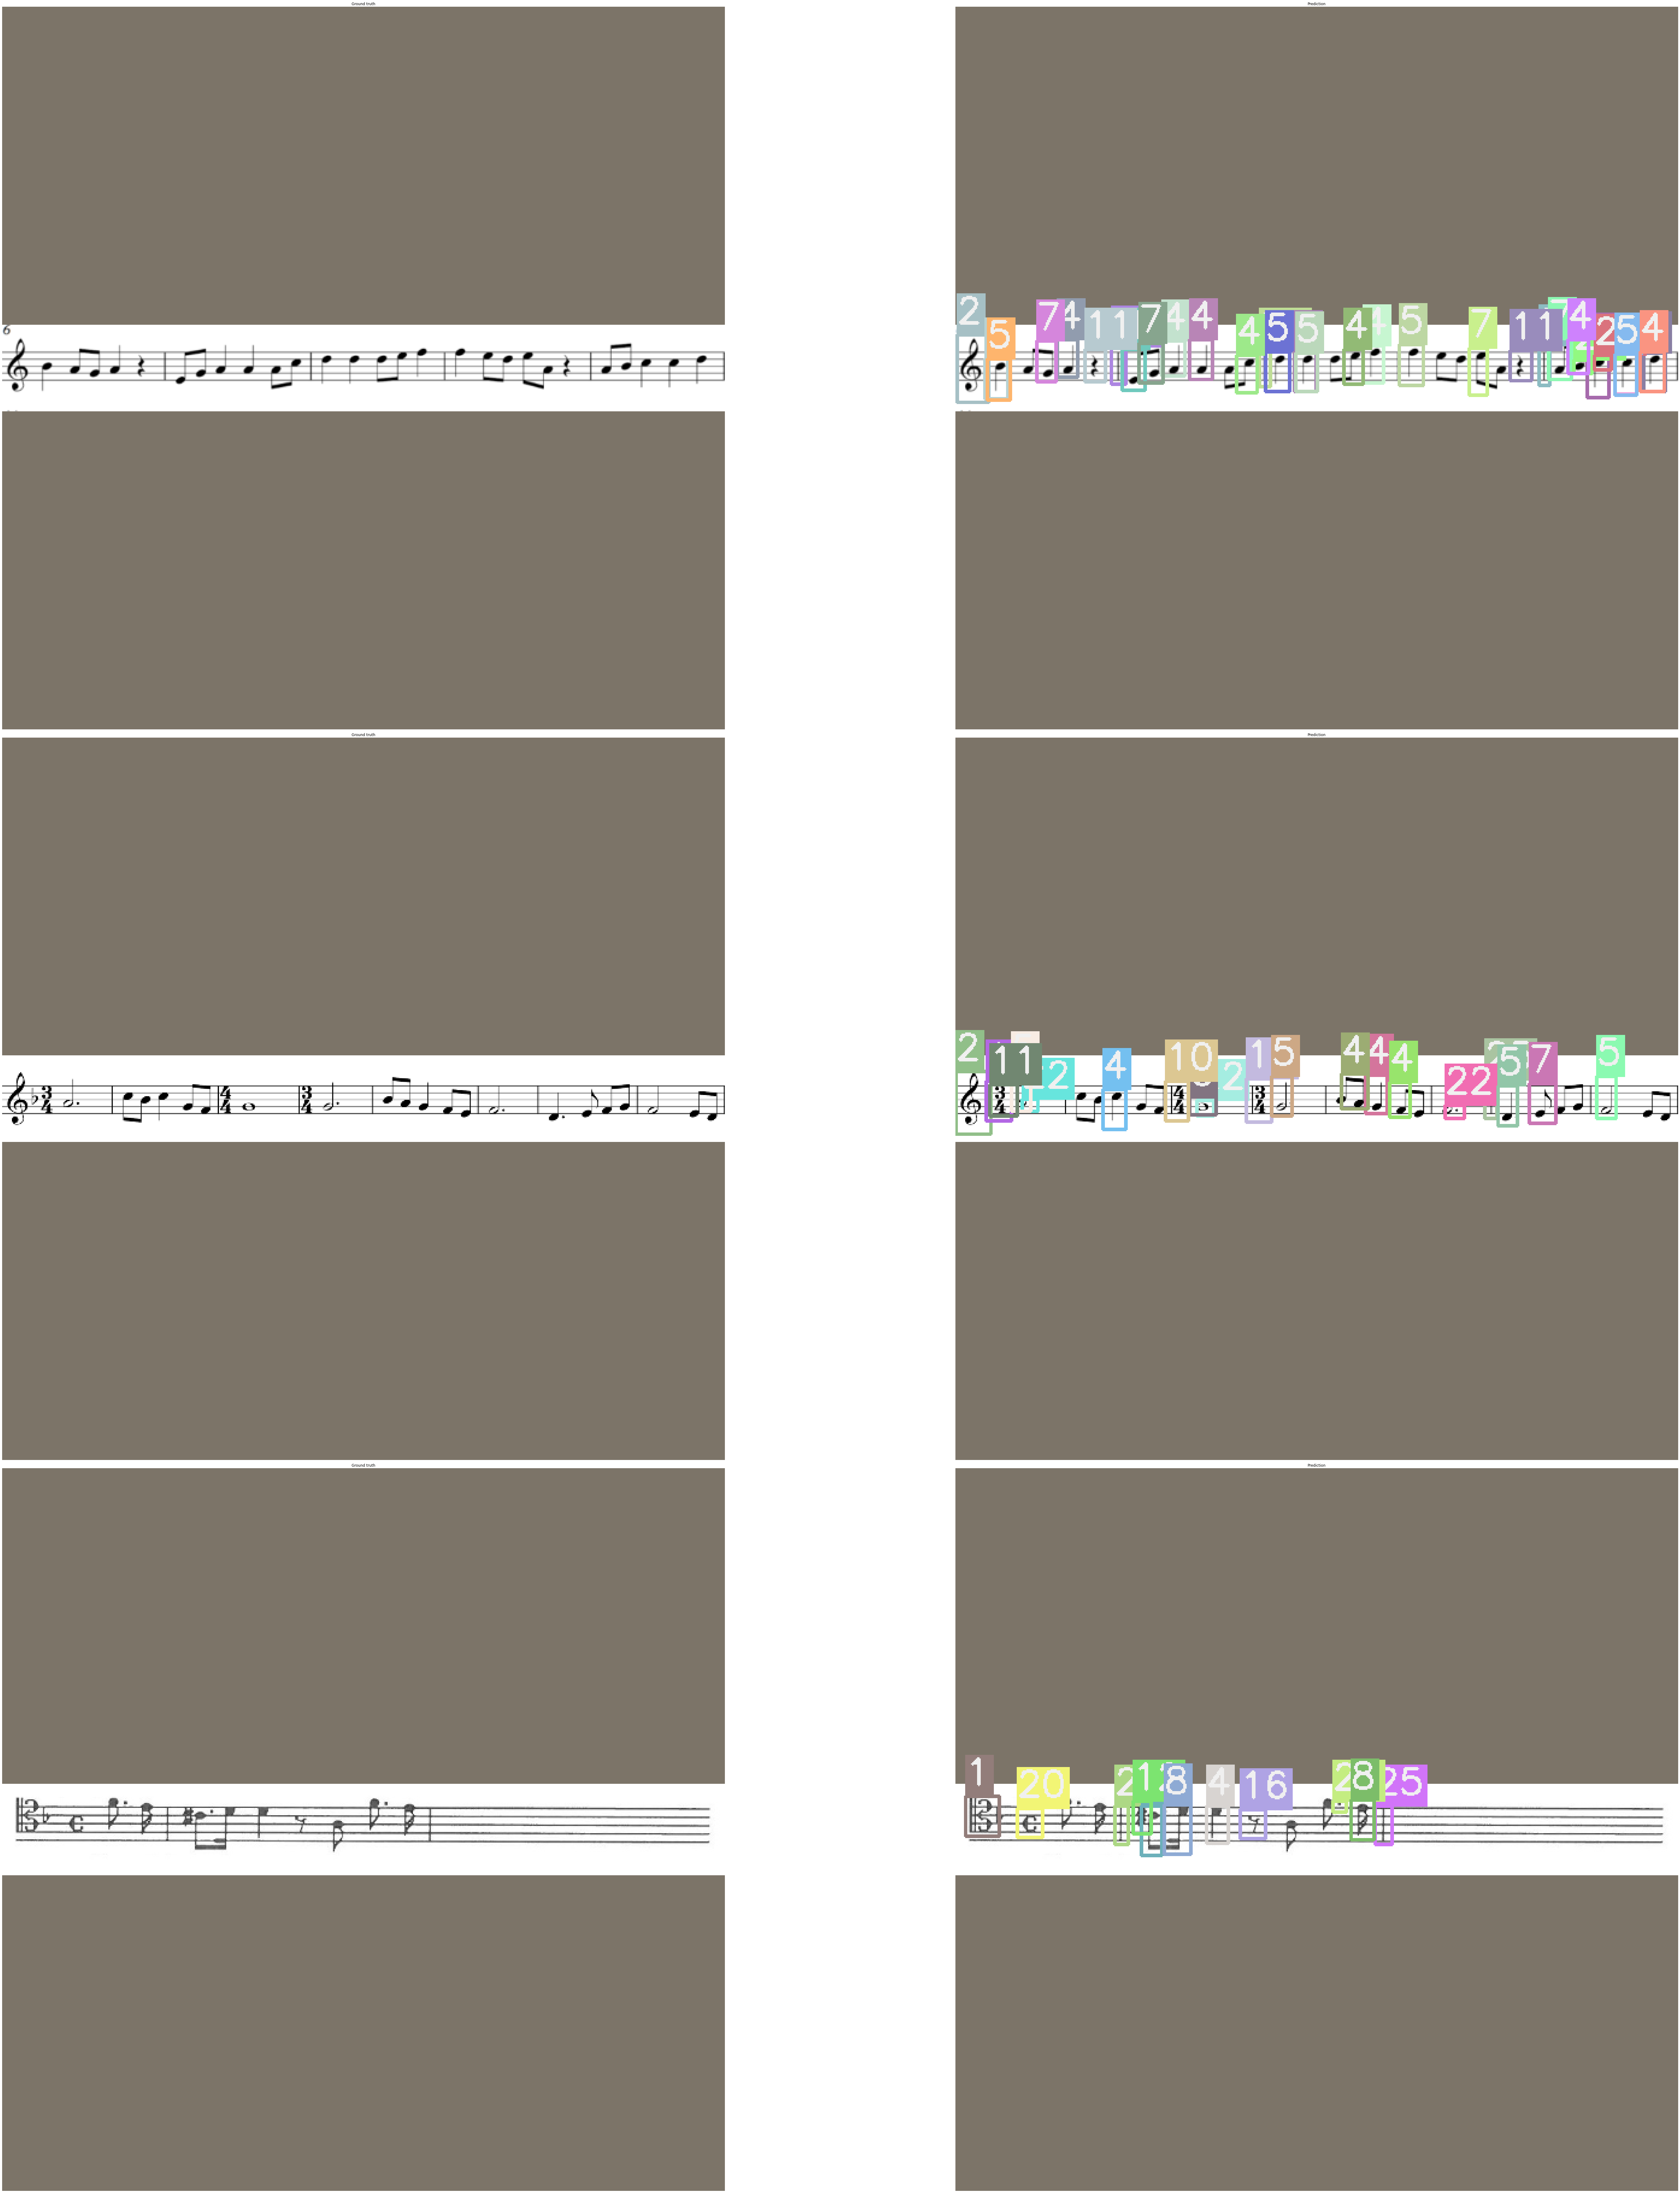

In [ ]:
show_preds(samples=samples, preds=preds,denormalize_fn=denormalize_imagenet,figsize=(100,100))

## Resultado final en conjunto de test